In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

from os import listdir
from os.path import isfile, join

import tensorflow as tf

from tensorflow.keras import callbacks, Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import average_precision_score

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
spec_dir = '../data/image_data/'
sample_dir = '../data/image_data/Polistes_dominula/'

paths_sample_plot = [join(sample_dir, f) for f in listdir(sample_dir) if isfile(join(sample_dir, f))]

- (b) View Batch

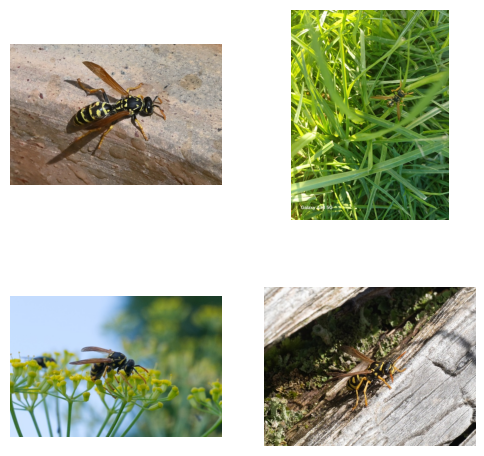

In [4]:
plt.figure(figsize=(6,6))

plt.subplot(221)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(222)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(223)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(224)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]));

Define Batch size

In [5]:
batch_size = 16

## B - <a name="generateurs"></a> Data Generators



In [6]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   )

test_data_generator  = ImageDataGenerator(rescale = 1./255)
data_generator  = ImageDataGenerator(rescale = 1./255)

- (d) Implement ```training_data```, ```valid_data``` splits


In [7]:
training_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "training", 
                                                   batch_size = batch_size)

validation_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "validation", 
                                                   batch_size = batch_size)

#test_data  = test_data_generator.flow_from_directory(directory = spec_dir,
#                                                   target_size = (224, 224),
#                                                   class_mode = 'binary',
#                                                   batch_size = batch_size)


Found 1951 images belonging to 16 classes.
Found 479 images belonging to 16 classes.


# II - <a name="classif"></a> Classification



In [8]:
base_model = MobileNet(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

# Add custom classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(16, activation='softmax')  # 16 output classes
])

In [9]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 4,
                                         mode = 'min',
                                         restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience=3,
                                         factor=0.5,
                                         verbose=2,
                                         mode='min',
                                         min_lr = 1e-6)

In [10]:
optimizer = Adam(learning_rate=0.0001) 

In [11]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

class AveragePrecisionCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator, num_classes=16):
        super().__init__()
        self.val_generator = val_generator
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        for i in range(len(self.val_generator)):
            x_batch, y_batch = self.val_generator[i]  # y_batch: shape (batch_size,)
            preds = self.model.predict(x_batch, verbose=0)  # preds: shape (batch_size, num_classes)

            y_true.extend(y_batch)
            y_pred.extend(preds)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # One-hot encode y_true to match y_pred's shape
        y_true_onehot = label_binarize(y_true, classes=range(self.num_classes))

        # Compute average precision per class
        aps = []
        for i in range(self.num_classes):
            ap = average_precision_score(y_true_onehot[:, i], y_pred[:, i])
            aps.append(ap)

        macro_ap = np.mean(aps)
        print(f"\nEpoch {epoch + 1}: val_average_precision = {macro_ap:.4f}")
        logs = logs or {}
        logs['val_average_precision'] = macro_ap


In [12]:
ap_callback = AveragePrecisionCallback(val_generator=validation_data)

In [13]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit(training_data, validation_data=validation_data, epochs=20, 
                    callbacks=[ap_callback,lr_plateau])

Epoch 1/20


c:\Users\dgnhk\anaconda3\envs\yevhenii\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.2208 - loss: 2.6370
Epoch 1: val_average_precision = 0.5915
122/122 ━━━━━━━━━━━━━━━━━━━━ 85s 574ms/step - accuracy: 0.2217 - loss: 2.6331 - val_accuracy: 0.4614 - val_loss: 1.7710 - val_average_precision: 0.5915 - learning_rate: 1.0000e-04
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.7993 - loss: 0.7910
Epoch 2: val_average_precision = 0.6946
122/122 ━━━━━━━━━━━━━━━━━━━━ 67s 545ms/step - accuracy: 0.7993 - loss: 0.7908 - val_accuracy: 0.6033 - val_loss: 1.3449 - val_average_precision: 0.6946 - learning_rate: 1.0000e-04
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9545 - loss: 0.3590
Epoch 3: val_average_precision = 0.7196
122/122 ━━━━━━━━━━━━━━━━━━━━ 67s 546ms/step - accuracy: 0.9544 - loss: 0.3590 - val_accuracy: 0.6618 - val_loss: 1.1591 - val_average_precision: 0.7196 - learning_rate: 1.0000e-04
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9946 - loss: 0.1692
Ep

KeyboardInterrupt: 

NameError: name 'history' is not defined

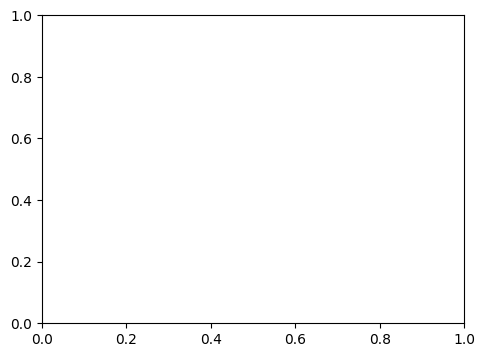

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
plt.show()

In [ ]:
#model.save('../models/my_model_epochs20.h5')